# Numerical Computing with Python
# Lecture  5: Partial Differential Equations
### Ramses van Zon
#### 26 November 2019

In [1]:
%%html
<style> h1, h2 { color: #2a7bbd ! important; } h1 { font-size: 2.5em !important; }  </style>

In [2]:
%matplotlib inline

In [3]:
def matrixprint(F):
    for i in range(len(F)):
        print ('|',end='')
        for el in F[i]:
            print("%010s "%str(el),end='')
        print('|')

## Today’s class

Today we will discuss the following topics:

  - Basic approaches to solving PDEs.
  - How to discretize equations.
  - How to implement boundary conditions.
  - Implicit versus explicit approaches.

## Partial Differential Equations

Partial differential equations (PDEs) are differential equations which
contain **derivatives of more than one variable**, e.g., two spatial coordinates, or space and time coordinates.

Second order PDEs are of the general form:

$$
 A\frac{\partial^2T}{\partial x^2} + B\frac{\partial^2 T}{\partial x\partial y}  + C\frac{\partial^2 T}{\partial y^2}
=f\left(x,y,T,\frac{\partial T}{\partial x}, \frac{\partial T}{\partial y}\right).
$$

For different combinations of A, B and C, three classes of PDEs show up repeatedly in
physical systems.

  - If $B^2 - 4AC < 0$, the equation is called elliptic.
  - If $B^2 - 4AC = 0$, the equation is called parabolic (diffusive).
  - If $B^2 - 4AC > 0$, the equation is called hyperbolic (wavelike).

## How do we solve these problems?

Let’s looking at a parabolic equation, in particular, let us
look at the ****heat equation****.

$$\frac{\partial T}{\partial t}=k\frac{\partial^2 T}{\partial x^2}$$

where $T$ is the temperature and $k$ is the thermal diffusivity.  Temperature varies along the spatial direction ($x$) and changes in time ($t$).

### How do we solve this equation?

By **discretizing** in both space and time,
and marching an initial condition forward in time.

*"Be wise, discretize!"* (Mark Kac)

## Calculating derivatives

We need to calculate the second spatial derivatives. How best to do that?

We **discretize** the $x$ domain, 

o--------o--------o--------o--------o 

$ j-2\:\,j-1\:\:\: j\:\:\:\:\:\:  j+1 \:\:   j+2$

and examine the **Taylor expansion** of the
function $T$, centered around three different points:

$$\begin{aligned}
T(x_{j-1}) &= T(x_j) - \Delta x \frac{\partial T(x_j)}{\partial x}
+ \frac{(\Delta x)^2}{2}\frac{\partial^2T(x_j)}{\partial x^2}+\mathcal O(\Delta x^3)\\
T(x_j) &= T(x_j) \\
T(x_{j+1}) &= T(x_j) + \Delta x \frac{\partial T(x_j)}{\partial x}
+ \frac{(\Delta x)^2}{2}\frac{\partial^2 T(x_j)}{\partial x^2}+\mathcal O(\Delta x^3)\end{aligned}
$$

Where $\Delta x=x_j-x_{j-1}$. 

Writing $T'=\partial T/\partial x$ and $T''=\partial^2 T/\partial x^2$, we get

$$
\begin{pmatrix}
T(x_{j-1})\\
T(x_{j})\\
T(x_{j+1})
\end{pmatrix}
=
\begin{pmatrix}
1 & -\Delta x & \Delta x^2 \\
1 & 0  & 0 \\
1 & +\Delta x & \Delta x^2 \\
\end{pmatrix}
\cdot
\begin{pmatrix}
T(x_j)\\T'(x_j)\\T''(x_j)
\end{pmatrix}
$$

To get the answer we **invert the matrix** (exactly):

$$
\begin{pmatrix}
T(x_j)\\T'(x_j)\\T''(x_j)
\end{pmatrix}
=
\begin{pmatrix}
0 & 1 & 0 \\
\frac{-1}{2\Delta x} & 0 & \frac{-1}{2\Delta x} \\
\frac{1}{\Delta x^2} & \frac{-2}{\Delta x^2}  & \frac{1}{\Delta x^2} 
\end{pmatrix}
\cdot
\begin{pmatrix}
T(x_{j-1})\\
T(x_{j})\\
T(x_{j+1})
\end{pmatrix}
$$

So we get the following for the **derivatives in terms of grid values**:

$$\displaystyle T'(x_j)=\frac{\partial T}{\partial x}
=\frac{T(x_{j+1})-T(x_{j-1})}{2\Delta x}$$

$$\displaystyle T''(x_j)=\frac{\partial^2T}{\partial x^2}
=\frac{T(x_{j+1})-2T(x_j)+T(x_{j-1})}{\Delta x^2}$$

## Discretized heat equation

$$\frac{\partial T_{j}}{\partial t} = k \left[\frac{T_{j+1}-2T_{j}+T_{j-1}}{\Delta x^2} \right]$$

Note that by discretizing space, we have turned our PDE into a set of ****coupled ODEs****!

If we write $T_{j}$ as a vector of values, we can rewrite our
equation as a ****matrix**** operation:

$$\frac{\partial T}{\partial t}=F\cdot T ,$$

where $F$ is the matrix

$$
F= \begin{pmatrix}
&&&\vdots&&&\\
\dots&k/\Delta x^2&-2k/\Delta x^2&k/\Delta x^2&0&0&\dots\\
\dots&0&k/\Delta x^2&-2k/\Delta x^2&k/\Delta x^2&0&\dots\\
\dots&0&0&k/\Delta x^2&-2k/\Delta x^2&k/\Delta x^2&\dots\\
&&&\vdots&&&
\end{pmatrix}.
$$

In [4]:
# for example:
N=6
F=[["-2k/Δx²" if i==j else "k/Δx²" if abs(i-j)<=1 else "0" for i in range(N)] for j in range(N)]
matrixprint(F)

|   -2k/Δx²      k/Δx²          0          0          0          0 |
|     k/Δx²    -2k/Δx²      k/Δx²          0          0          0 |
|         0      k/Δx²    -2k/Δx²      k/Δx²          0          0 |
|         0          0      k/Δx²    -2k/Δx²      k/Δx²          0 |
|         0          0          0      k/Δx²    -2k/Δx²      k/Δx² |
|         0          0          0          0      k/Δx²    -2k/Δx² |


## What about the boundaries?

The boundaries are a problem. Why? Well, consider the first point, $j = 0$:

$$\frac{\partial T_{0}}{\partial t}=
k\left[\frac{T_{1}-2T_{0}+T_{-1}}{\Delta x^2}\right]
$$

There is no $j = -1$ point!

The solution to the boundary problem is **not to use the above equation for the edge points**, but to use a different equation instead. These are known as **boundary conditions**.

How these conditions are implemented, depends on the approach to solving
the equation that is being used.

## Example problem

### Suppose:

  * We have a rod of length 1.

  * At the left boundary ($x = 0$), the temperature varies as $T (t, 0) = \sin(10t)$.

  * The right boundary ($x = 1$) is kept at a constant temperature of $T(t, 1) = 0$.

  * The thermal diffusivity is $k = 0.2$.

Show how the temperature evolves in time and space.

### How should we solve this problem?

As mentioned two lectures ago, there are two basic classes of approaches:

  - explicit methods
  - implicit methods

## Using the implicit method

As mentioned two lectures ago, explicit methods can be unstable. So we will
solve our probltm using an implicit method. We start by returning to our
equation:

$$\frac{\partial T_i}{\partial t} = F\cdot T_i$$

Using **backward Euler**, we rewrite this approximately as

$$\frac{T_{i+1}-T_i}{\Delta t} = F\cdot T_{i+1}$$

which, after some rearranging, gives:

$$(\mathbf{1}-\Delta t F)\cdot T_{i+1} = T_i$$

where $\bf 1$ is the identity matrix.

## Implementing boundary conditions

The boundary conditions are implemented by modifying the operator $F$ in

$$(\mathbf 1 - \Delta t F)\cdot T_{i+1} = T_i$$

The equation for the boundary condition
($T_{i+1,j=0} = \sin(10t_{i+1})$) could be implemented by:

$$
\begin{pmatrix}
\sin(10t_i)/\sin(10t_{i+1})  & 0         & 0         & 0 & \dots\\
-\alpha                      & 1+2\alpha & -\alpha   & 0 & \dots\\
0                            & -\alpha   & 1+2\alpha & -\alpha & \dots\\
                             &           & \vdots    &&
\end{pmatrix}
\cdot
\begin{pmatrix}
T_{i+1,0}\\
T_{i+1,1}\\
T_{i+1,2}\\
\vdots
\end{pmatrix}
=\begin{pmatrix}
T_{i,0}\\
T_{i,1}\\
T_{i,2}\\
\vdots
\end{pmatrix}
$$

Where we have defined a new constant: $\alpha=\Delta t k /\Delta x^2$.

This approach may cause singularities; better is to
**replace the top-left element of the matrix with a $1$**,
and to **modify $T_{i+1,j=0}$ after each step** to the correct value.

In [5]:
A=[["1+2Δt"+F[i][j][2:] if i==j else "-Δt"+F[i][j] if F[i][j] != '0' else F[i][j] for i in range(N)] for j in range(N)]
A[0]=["1"]+["0"]*(N-1)
matrixprint(A)

|         1          0          0          0          0          0 |
|  -Δtk/Δx² 1+2Δtk/Δx²   -Δtk/Δx²          0          0          0 |
|         0   -Δtk/Δx² 1+2Δtk/Δx²   -Δtk/Δx²          0          0 |
|         0          0   -Δtk/Δx² 1+2Δtk/Δx²   -Δtk/Δx²          0 |
|         0          0          0   -Δtk/Δx² 1+2Δtk/Δx²   -Δtk/Δx² |
|         0          0          0          0   -Δtk/Δx² 1+2Δtk/Δx² |


## Implementing the other boundary condition

Assume that there are 100 points in $x$.

The boundary condition
equation at $x = 1$ ($T_{i+1,j=99}$ = 0) is implemented similarly, but
slightly simpler: 

$$
\begin{pmatrix}
&&\vdots&&\\
\dots & -\alpha & 1+2\alpha & -\alpha    & 0 \\
\dots & 0      & -\alpha    & 1+2\alpha & -\alpha\\
\dots & 0      & 0         & 0         & 1 \\
\end{pmatrix}
\cdot
\begin{pmatrix}
\vdots\\
T_{i+1,97}\\
T_{i+1,98}\\
T_{i+1,99}
\end{pmatrix}
=\begin{pmatrix}
\vdots\\
T_{i,97}\\
T_{i,98}\\
T_{i,99}
\end{pmatrix}
$$

This works automatically if we set $T_{i,99}=0$ initially, but
alternatively, we can set $T_{i+1,99}=0$ after each step.

In [6]:
A[N-1]=["0"]*(N-1)+["1"]
matrixprint(A)

|         1          0          0          0          0          0 |
|  -Δtk/Δx² 1+2Δtk/Δx²   -Δtk/Δx²          0          0          0 |
|         0   -Δtk/Δx² 1+2Δtk/Δx²   -Δtk/Δx²          0          0 |
|         0          0   -Δtk/Δx² 1+2Δtk/Δx²   -Δtk/Δx²          0 |
|         0          0          0   -Δtk/Δx² 1+2Δtk/Δx²   -Δtk/Δx² |
|         0          0          0          0          0          1 |


## The time stepping algorithm

So what is the actual process?

$$(\mathbf 1 - \Delta t F)\cdot T_{i+1} = T_i$$

  * This equation needs to be solved for $T_{i+1}$, and is of the form $A\cdot x = b$.
  * Build the **matrix** operator $A=\mathbf 1 - \Delta t F$.
  * Modify the operator $A$ to deal with the **boundary** conditions.
  * **Initialize** $T$
  * Then **loop**:
      - Copy the current value of $T$ to a temporary variable $b$.
      - **Solve** $A T = b$ (linear algebra!)
      - **Correct boundary** values.
  * And repeat **until time is up**.

/home/rzon/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


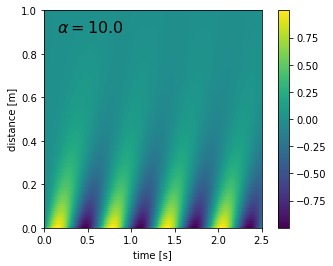

In [8]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt

k = 0.2
t1 = 0
t2 = 2.5
x1 = 0
x2 = 1
nx = 100
x = np.linspace(x1,x2,nx+1)
dx = x[1]-x[0]

dt = 0.005
nt = int((t2-t1)/dt)
alpha = dt*k/dx**2

# allocate the temparature array
T = np.zeros(nx)

# allocate an array to plot the image
TasImage = np.zeros([nx,nt+1])

# build matrix
A = np.zeros([nx,nx])
for j in range(1,nx-1):
    A[j,j-1] = -alpha
    A[j,j] = 1 + 2*alpha
    A[j,j+1] = -alpha
# first and last element are different because of the boundary conditions
A[0,0] = 1
A[nx-1,nx-1] = 1

# add to the image
TasImage[:,0] = np.flip(T).copy()

for i in range(1,nt):
    t = t1 + i*dt
    b = T.copy()
    T = la.solve(A,b)
    # re-adjust boundary condition
    T[0] = np.sin(10*t)
    T[nx-1] = 0
    # add to the image
    TasImage[:,i] = np.flip(T).copy()
       
# visualize the result
plt.imshow(TasImage, aspect='equal', extent=[t1,t2,x1,x2])
plt.axes().set_aspect((t2-t1)/(x2-x1))
plt.xlabel('time [s]')
plt.ylabel('distance [m]')
plt.colorbar()
plt.text(t1+0.06*(t2-t1),0.9*(x2-x1)+x1,r"$\alpha="+str(alpha)+"$",size=16,color='k');

## Notes about the example

Some things to note:

  * When solving $(1 - \Delta t F )\cdot T = b$, **do NOT invert the operator A**.

    Using the inverse matrix may seem to be the intuitive thing to do, and scipy.linalg
    can do it, but it is incorrect.  There are better, faster, and
    more accurate algorithms for solving this problem.

    *[www.johndcook.com/blog/2010/01/19/dont-invert-that-matrix](https://www.johndcook.com/blog/2010/01/19/dont-invert-that-matrix)*

  * Because we are using an implicit method, this solution will be
    **numerically stable** for arbitrary timestep size (this can be
    demonstrated mathematically).

  * However, for **accuracy** of solution one
    must have $\alpha <1$.

  * We’ve used the most general method to solve $Ax = b$. However, you
    will notice that our operator is banded. In such situations, there are
    **special algorithms** for solving $Ax = b$, the one to use in Python is
    `linalg.solve_banded`.

## Using the explicit method

As mentioned last lecture, explicit methods can be unstable. Let’s see how
it performs in this case. We start by returning to our equation:

$$\frac{\partial T_i}{\partial t} = F \cdot T_i$$

We rewrite this as\tightsep

$$\frac{T_{i+1}-T_i}{\Delta t} = F\cdot T_{i}$$

which, after some rearranging, gives:

$$T_{i+1} = (\mathbf{1}+\Delta t F)\cdot T_i$$


This is obviously much more direct: just **matrix-vector multiplication**.

Boundary conditions, surprisingly, are dealt with in the same way as
for the explicit method.

## Explicit results

Implementation:

```python
# heatexplicit.py
...
for i in range(1,nt):
    t = t1 + i*dt
    # explicit solve
    b = T.copy()
    T = A @ b
    # re-adjust boundary condition
    T[0] = np.sin(10*t)
    T[nx-1] = 0
...
```

![](xalpha10.0.png)

There’s a problem here.

In [ ]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt

k = 0.2
t1 = 0
t2 = 2.5
x1 = 0
x2 = 1
nx = 100
x = np.linspace(x1,x2,nx+1)
dx = x[1]-x[0]
dt = 0.005

nt = int((t2-t1)/dt)
alpha = dt*k/dx**2

# allocate the temparature array
T = np.zeros(nx)

# allocate an array to plot the image
TasImage = np.zeros([nx,nt+1])

# build matrix
Atilde = np.zeros([nx,nx])
for j in range(1,nx-1):
    Atilde[j,j-1] = +alpha
    Atilde[j,j] = 1 - 2*alpha
    Atilde[j,j+1] = +alpha
# first and last element are different because of the boundary conditions
Atilde[0,0] = 1
Atilde[nx-1,nx-1] = 1

TasImage[:,0] = np.flip(T).copy()

for i in range(1,nt):
    t = t1 + i*dt
    b = T.copy()
    # explicit solve (skip to avoid nans)
    if (t<0.99 or alpha<0.11 ):
       T = Atilde @ b
    # re-adjust boundary condition
    T[0] = np.sin(10*t)
    T[nx-1] = 0
    TasImage[:,i] = np.flip(T).copy()
      
plt.imshow(TasImage, aspect='equal', extent=[t1,t2,x1,x2])
plt.axes().set_aspect((t2-t1)/(x2-x1))
plt.xlabel('time [s]')
plt.ylabel('distance [m]')
plt.colorbar()
plt.text(t1+0.06*(t2-t1),0.9*(x2-x1)+x1,r"$\alpha="+str(alpha)+"$",size=16,color='k');

## Can we escape the instability?

Yes, we can, we just need to pick a better value of α, i.e., a smaller timestep for the implicit method.

In [ ]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt

k = 0.2
t1 = 0
t2 = 2.5
x1 = 0
x2 = 1
nx = 100
x = np.linspace(x1,x2,nx+1)
dx = x[1]-x[0]
dt = 0.00005

nt = int((t2-t1)/dt)
alpha = dt*k/dx**2

# allocate the temparature array
T = np.zeros(nx)

# allocate an array to plot the image
TasImage = np.zeros([nx,nt+1])

# build matrix
Atilde = np.zeros([nx,nx])
for j in range(1,nx-1):
    Atilde[j,j-1] = +alpha
    Atilde[j,j] = 1 - 2*alpha
    Atilde[j,j+1] = +alpha
# first and last element are different because of the boundary conditions
Atilde[0,0] = 1
Atilde[nx-1,nx-1] = 1

TasImage[:,0] = np.flip(T).copy()

for i in range(1,nt):
    t = t1 + i*dt
    b = T.copy()
    # explicit solve (skip to avoid nans)
    if (t<0.99 or alpha<0.11 ):
       T = Atilde @ b
    # re-adjust boundary condition
    T[0] = np.sin(10*t)
    T[nx-1] = 0
    TasImage[:,i] = np.flip(T).copy()
      
plt.imshow(TasImage, aspect='equal', extent=[t1,t2,x1,x2])
plt.axes().set_aspect((t2-t1)/(x2-x1))
plt.xlabel('time [s]')
plt.ylabel('distance [m]')
plt.colorbar()
plt.text(t1+0.06*(t2-t1),0.9*(x2-x1)+x1,r"$\alpha="+str(alpha)+"$",size=16,color='k');

But a smaller time step slows down the time-to-solution substantially.

****Implicit methods are more complicated, but worth it.****

## Final notes on PDEs and linear algebra

  * We only scratched the surface for PDEs. We've not discussed
    finite-volume vs. finite-element, or spectral methods.  Nor have
    we looked at hyperbolic and elliptic equations.
    
  * There is a lot more linear algebra in SciPy.    
    *Decompositions, inverses, determinants, eigenvalues, special matrices*    
    *[docs.scipy.org/doc/scipy/reference/linalg.html](https://docs.scipy.org/doc/scipy/reference/linalg.htmlhttps://docs.scipy.org/doc/scipy/reference/linalg.html)*

  * SciPy's routines use low-level routines from BLAS and LAPACK,
    which often use highly optimized codes (MKL, ESSL, ...).
    
  * Implicit is better (faster, more stable) than explicit.
    
  * Never invert a matrix numerically.